In [1]:
# System
import os

# Data processing
import numpy as np

# Results presentation
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

# NN related stuff
import torch
from torch.utils.data import Dataset, DataLoader

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [2]:
DEVICE_ID = 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(DEVICE_ID)
print (DEVICE)

cuda


In [3]:
N_CELLS_HOR = 200
N_CELLS_VER = 250

In [4]:
celled_data = torch.load("Data/celled_data_"
                         + str(N_CELLS_HOR)
                         + "x"
                         + str(N_CELLS_VER))
print (celled_data.shape)

torch.Size([9591, 1, 200, 250])


In [5]:
OBSERVED_DAYS = 64     # ~2 months
DAYS_TO_PREDICT_AFTER  = 10
DAYS_TO_PREDICT_BEFORE = 50
TESTING_DAYS = 1000

HEAVY_QUAKE_THRES = 3.5

In [6]:
freq_map = (celled_data>HEAVY_QUAKE_THRES).float().mean(dim=0)

In [7]:
class Dataset_RNN_Test (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[(celled_data.shape[0] -
                                 TESTING_DAYS):
                                (celled_data.shape[0])]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
        print ('self.data :', self.data.shape)
        print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[(idx)],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)

In [8]:
dataset_test  = Dataset_RNN_Test(celled_data)

dataloader_test  = DataLoader(dataset_test,
                              batch_size=1,
                              shuffle=False,
                              num_workers=1)

self.data : torch.Size([1000, 1, 200, 250])
size      : 950


In [9]:
from model import *

In [10]:
RNN_cell = LSTMCell(freq_map,
                    embedding_size    = EMB_SIZE,
                    hidden_state_size = HID_SIZE,
                    n_cells_hor       = N_CELLS_HOR,
                    n_cells_ver       = N_CELLS_VER,
                    device            = DEVICE)

RNN_cell.load_state_dict(torch.load("Model/state_dict"))
_ = RNN_cell.eval()

In [11]:
def my_precision_TPR_FPR (input, target, threshold):
    TP = torch.sum ((  (input>threshold) .float() * target      ).float())
    FP = torch.sum ((  (input>threshold) .float() * (1 - target)).float())
    FN = torch.sum (((~(input>threshold)).float() * target      ).float())
    TN = torch.sum (((~(input>threshold)).float() * (1 - target)).float())
    return TP / (TP + FP), TP / (TP + FN), FP / (FP + TN)

def check_quality (RNN_cell,
                   device,
                   dataloader_test,
                   n_dots=501,
                   info_file=None):
    
    prediction = torch.zeros(dataloader_test.__len__(),  N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    prediction.detach_()
    target     = torch.zeros(dataloader_test.__len__(), N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    target.detach_()
       
    RNN_cell.to(device)

    hid_state = RNN_cell.init_state(batch_size=1, device=device)
    if (type(hid_state) == tuple):
        for elem in hid_state:
            elem.detach_()
    else:
        hid_state.detach_()
        
    i = 0
    for data in tqdm(dataloader_test):

        inputs = data[0].to(device)
        labels = data[1].to(device).float()

        hid_state, outputs = RNN_cell.forward(inputs, hid_state)
        
        prediction[i] = outputs[:, 1, :, :]
        target    [i] = labels.squeeze(0)
    
        if (type(hid_state) == tuple):
            for elem in hid_state:
                elem.detach_()
        else:
            hid_state.detach_()
        prediction.detach_()
        target    .detach_()
        i += 1
        
    assert prediction.shape == target.shape
    prediction = prediction [10:prediction.shape[0]]  # cutting peace of data because
    target     = target     [10:target    .shape[0]]  # hidden state might be not good
    
    print ("ROC_AUC_score = ", end='')
    ROC_AUC_score = roc_auc_score(np.array(target    .view(-1).cpu()),
                                  np.array(prediction.view(-1).cpu()))
    print (ROC_AUC_score)
    
    print ("AVG_precision_score = ", end='')
    AVG_precision_score = average_precision_score(np.array(target    .view(-1).cpu()),
                                                  np.array(prediction.view(-1).cpu()))
    print (AVG_precision_score)
    
    threshold_massive = torch.linspace (0, 1, n_dots, dtype=torch.float, device=device)
    
    precision_massive = []
    recall_massive    = []
    FPR_massive       = []
    
    for threshold in tqdm(threshold_massive):
        precision, recall, FPR = my_precision_TPR_FPR(prediction, target, threshold)
        precision_massive.append(precision.item())
        recall_massive   .append(recall.item())
        FPR_massive      .append(FPR.item())
    
    # plot 1 precision
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), precision_massive, color='green', marker='.')

    axes.set_xlabel('threshold')
    axes.set_ylabel('precision')

    plt.show()
    
    # plot 2 recall
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), recall_massive, color='green', marker='.')

    axes.set_xlabel('threshold')
    axes.set_ylabel('recall')
    
    plt.show()
    
    # plot 3 ROC-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(FPR_massive, recall_massive, 'orange', marker = '.')
    axes.plot (range(2), range(2), 'grey', ls='--')

    axes.set_xlabel('FPR')
    axes.set_ylabel('TPR (recall)')
    axes.set_title('ROC-curve')

    plt.show()
    
    # plot 4 precision-recall-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(recall_massive, precision_massive, 'orange', marker = '.')

    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    axes.set_title('Precision_Recall_curve')

    plt.show()
    
    return ROC_AUC_score, AVG_precision_score


ROC_AUC_score = 0.9652399350624512
AVG_precision_score = 0.08155147254811948


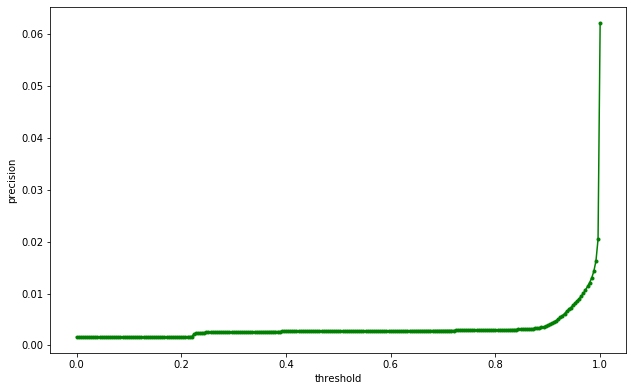

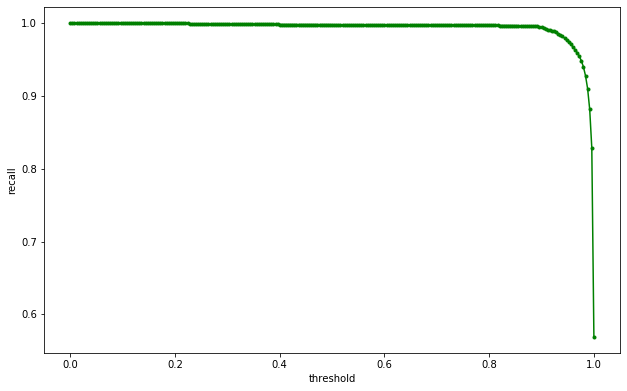

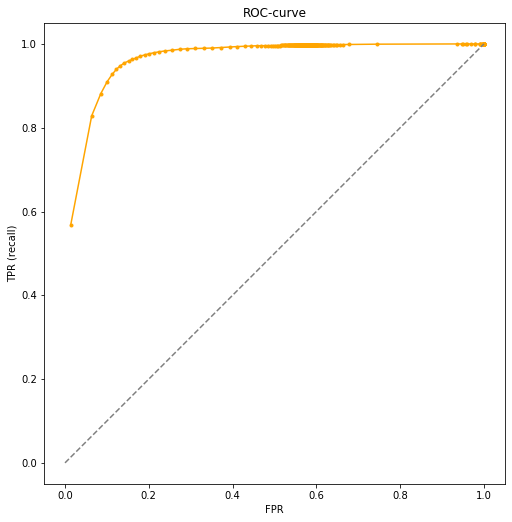

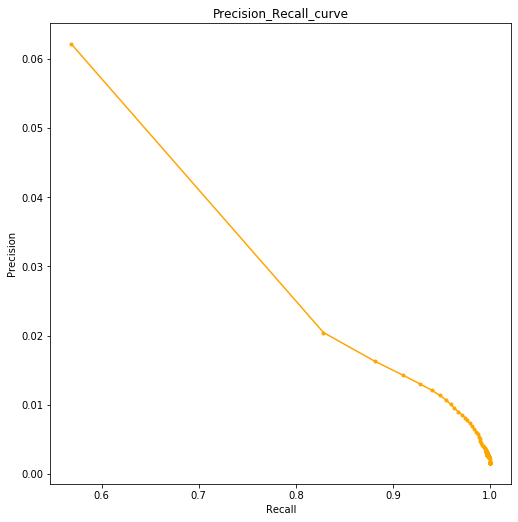

In [12]:
RNN_cell.eval()

ROC_AUC, AVG_prec = check_quality (RNN_cell,
                                   DEVICE,
                                   dataloader_test,
                                   n_dots=251)
